In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter

Supervised NLP requires a pre-labelled dataset for training and testing, and is generally interested in categorizing text in various ways. In this case, we are going to try to predict whether a sentence comes from _Alice in Wonderland_ by Lewis Carroll or _Persuasion_ by Jane Austen. We can use any of the supervised models we've covered previously, as long as they allow categorical outcomes. In this case, we'll try Random Forests, SVM, and KNN.

Our feature-generation approach will be something called _BoW_, or _Bag of Words_. BoW is quite simple: For each sentence, we count how many times each word appears. We will then use those counts as features.  

In [2]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text
    
# Load and clean the data.
persuasion = gutenberg.raw('austen-persuasion.txt')
alice = gutenberg.raw('carroll-alice.txt')

# The Chapter indicator is idiosyncratic
persuasion = re.sub(r'Chapter \d+', '', persuasion)
alice = re.sub(r'CHAPTER .*', '', alice)
    
alice = text_cleaner(alice)
persuasion = text_cleaner(persuasion)

In [3]:
# Parse the cleaned novels. This can take a bit.
nlp = spacy.load('en')
alice_doc = nlp(alice)
persuasion_doc = nlp(persuasion)

In [4]:
# Group into sentences.
alice_sents = [[sent, "Carroll"] for sent in alice_doc.sents]
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]

print(len(alice_sents))
print(len(persuasion_sents))

1669
3649


In [5]:
#For computational purposes, reduce length of alice_sents to 1000
alice_sents = alice_sents[0:750]
persuasion_sents = persuasion_sents[0:750]

In [6]:
# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(alice_sents + persuasion_sents)
sentences.head()

,0,1
0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,"(So, she, was, considering, in, her, own, mind...",Carroll
2,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,"(Oh, dear, !)",Carroll
4,"(I, shall, be, late, !, ')",Carroll


Time to bag some words!  Since spaCy has already tokenized and labelled our data, we can move directly to recording how often various words occur.  We will exclude stopwords and punctuation.  In addition, in an attempt to keep our feature space from exploding, we will work with lemmas (root words) rather than the raw text terms, and we'll only use the 2000 most common words for each text.

In [7]:
# Utility function to create a list of the 1500 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
        
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(1000)]

In [8]:
# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
alicewords = bag_of_words(alice_doc)
persuasionwords = bag_of_words(persuasion_doc)

# Combine bags to create a set of unique words.
common_words = set(alicewords + persuasionwords)

In [9]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 500
Processing row 1000


,directly,now,happy,impression,happiness,fully,knot,intercourse,tart,improve,...,a,however,sacrifice,impossible,offend,dog,affect,thump,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(So, she, was, considering, in, her, own, mind...",Carroll
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Oh, dear, !)",Carroll
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(I, shall, be, late, !, ')",Carroll


In [10]:
word_counts.shape

(1500, 1563)

## Trying out BoW

Now let's give the bag of words features a whirl by trying a random forest.

In [11]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.98

Test set score: 0.8466666666666667


Holy overfitting, Batman! Overfitting is a known problem when using bag of words, since it basically involves throwing a massive number of features at a model – some of those features (in this case, word frequencies) will capture noise in the training set. Since overfitting is also a known problem with Random Forests, the divergence between training score and test score is expected.


## BoW with Logistic Regression

Let's try a technique with some protection against overfitting due to extraneous features – logistic regression with ridge regularization (from ridge regression, also called L2 regularization).

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(900, 1561) (900,)
Training set score: 0.9677777777777777

Test set score: 0.875


Logistic regression performs a bit better than the random forest.  

# BoW with Gradient Boosting

And finally, let's see what gradient boosting can do:

In [13]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.9033333333333333

Test set score: 0.81


Looks like logistic regression is the winner, but there's room for improvement.

# Same model, new inputs

What if we feed the model a different novel by Jane Austen, like _Emma_?  Will it be able to distinguish Austen from Carroll with the same level of accuracy if we insert a different sample of Austen's writing?

First, we need to process _Emma_ the same way we processed the other data, and combine it with the Alice data:

In [14]:
# Clean the Emma data.
emma = gutenberg.raw('austen-emma.txt')
emma = re.sub(r'VOLUME \w+', '', emma)
emma = re.sub(r'CHAPTER \w+', '', emma)
emma = text_cleaner(emma)
print(emma[:100])

Emma Woodhouse, handsome, clever, and rich, with a comfortable home and happy disposition, seemed to


In [15]:
# Parse our cleaned data.
emma_doc = nlp(emma)

In [16]:
# Group into sentences.
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]
emma_sents = [[sent, "Austen"] for sent in emma_doc.sents]

# Emma is quite long, let's cut it down to the same length as Alice.
emma_sents = emma_sents[0:len(alice_sents)]

In [17]:
# Build a new Bag of Words data frame for Emma word counts.
# We'll use the same common words from Alice and Persuasion.
emma_sentences = pd.DataFrame(emma_sents)
emma_bow = bow_features(emma_sentences, common_words)

print('done')

Processing row 0
Processing row 500
done


In [18]:
# Now we can model it!
# Let's use logistic regression again.

# Combine the Emma sentence data with the Alice data from the test set.
X_Emma_test = np.concatenate((
    X_train[y_train[y_train=='Carroll'].index],
    emma_bow.drop(['text_sentence','text_source'], 1)
), axis=0)
y_Emma_test = pd.concat([y_train[y_train=='Carroll'],
                         pd.Series(['Austen'] * emma_bow.shape[0])])

# Model.
print('\nTest set score:', lr.score(X_Emma_test, y_Emma_test))
lr_Emma_predicted = lr.predict(X_Emma_test)
pd.crosstab(y_Emma_test, lr_Emma_predicted)


Test set score: 0.6593959731543624


col_0,Austen,Carroll
row_0,,
Austen,567,183
Carroll,223,219


Well look at that!  NLP approaches are generally effective on the same type of material as they were trained on. It looks like this model is actually able to differentiate multiple works by Austen from Alice in Wonderland.  Now the question is whether the model is very good at identifying Austen, or very good at identifying Alice in Wonderland, or both...

# Challenge 0:

Recall that the logistic regression model's best performance on the test set was 87.5%.  See what you can do to improve performance.  Suggested avenues of investigation include: Other modeling techniques (SVM?), making more features that take advantage of the spaCy information (include grammar, phrases, POS, etc), making sentence-level features (number of words, amount of punctuation), or including contextual information (length of previous and next sentences, words repeated from one sentence to the next, etc), and anything else your heart desires.  Make sure to design your models on the test set, or use cross_validation with multiple folds, and see if you can get accuracy above 90%.  

# Feature Engineering

In [19]:
#Look at sparsity of columns (words) and only take columns above a certain threshold

#Create empty dataframe first
raw_data_non_zero = pd.DataFrame(columns=['Column_Name', 'Count', 'Percentage'])

#Go through each column and find the sum of non-zero rows
for col in word_counts:
    non_zero_count = word_counts[col].astype(bool).sum(axis=0)
    raw_data_non_zero = raw_data_non_zero.append({'Column_Name': col, 'Count':non_zero_count, 'Percentage':round((non_zero_count/1500)*100, 2)}, ignore_index=True)

In [20]:
#Confirm this worked

New_feature_set = raw_data_non_zero.sort_values('Percentage', ascending=True)
New_feature_set.head(10)

,Column_Name,Count,Percentage
1071,moral,0,0.0
748,fun,0,0.0
116,witness,0,0.0
117,gryphon,0,0.0
746,snail,0,0.0
119,arch,0,0.0
1509,purpose,0,0.0
121,whiting,0,0.0
764,hedgehog,0,0.0
739,gratification,0,0.0


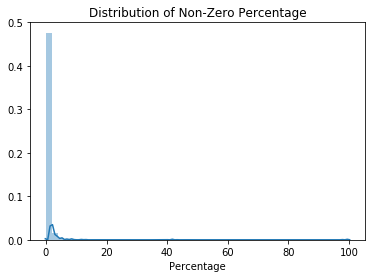

In [21]:
#Look at distribution of Percentage

#Temp data frame
sns.distplot(New_feature_set['Percentage'])
plt.title('Distribution of Non-Zero Percentage')
plt.show()

Based on this output, it makes sense to leave the features as is due to high amount of sparsity across the entire df, with the exception of our actual sentences/authors.

**Count of Parts of Speech Feature

In [22]:
#Create function for getting parts of speech

def get_pos(df):
    all_pos= []
    for i, sentence in enumerate(df['text_sentence']):
        for token in sentence:
            if token.pos != 0:
                all_pos.append(token.pos_)
    return all_pos

In [23]:
#Create unique column for each entity in words_count

pos_types = set(get_pos(word_counts))
pos = pd.DataFrame(columns=pos_types)
word_counts = pd.concat([word_counts, pos], axis=1)
word_counts.loc[:, pos_types] = 0

In [24]:
#Finally, produce counts for each entity by sentence

for i, sentence in enumerate(word_counts['text_sentence']):
    for token in sentence:
        if token.pos != 0:
            word_counts.loc[i, token.pos_] += 1

**Count of Entities Feature

In [25]:
#Create function for getting entity types

def get_entity_types(df):
    all_entities= []
    for i, sentence in enumerate(df['text_sentence']):
        for token in sentence:
            if token.ent_type != 0:
                all_entities.append(token.ent_type_)
    return all_entities

In [26]:
#Create unique column for each entity in words_count

entity_types = set(get_entity_types(word_counts))
entities = pd.DataFrame(columns=entity_types)
word_counts = pd.concat([word_counts, entities], axis=1)
word_counts.loc[:, entity_types] = 0

In [27]:
#Finally, produce counts for each entity by sentence

for i, sentence in enumerate(word_counts['text_sentence']):
    for token in sentence:
        if token.ent_type != 0:
            word_counts.loc[i, token.ent_type_] += 1

**Count of Words in Sentence Feature

In [28]:
#Count of words in sentence

word_counts['word_count'] = 0

for i, sentence in enumerate(word_counts['text_sentence']):
    words = len([token for token in sentence if not token.is_punct])
        
    # Populate the row with word counts.
    word_counts.loc[i, 'word_count'] += words

# Model Building

**Note:** Limited number of common words in each text to 1000 and number of sentences to 750 due to computational constraints. For that reason, best model was still logistic regression but accuracy observed at 87.5% instead of 93% in the curriculum.

## First try Logistic Regression, then Lasso Logistic Regression

In [29]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

lr = LogisticRegression()
Y = word_counts['text_source']
X = word_counts.drop(['text_sentence','text_source'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = lr.fit(X_train, y_train)

print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

Training set score: 0.9766666666666667

Test set score: 0.87


In [30]:
#Try Lasso Logistic Regression, find the right parameters

from sklearn.model_selection import cross_val_score

def run_model(model):
    if model == 'Lasso':
        lasso = np.arange(0.2, 1.0, 0.2)
        lasso_df = pd.DataFrame()
        for i in lasso:
            lr_lasso = LogisticRegression(penalty='l1', C=i)
            lr_lasso.fit(X, Y)
            positive_pred = lr_lasso.predict(X)
            cross_val = cross_val_score(lr_lasso, X, Y, cv=5).mean()*100
            score = lr_lasso.score(X, Y)*100
            lasso_df_temp = pd.DataFrame({'C': i, 'training': score, 'test': cross_val}, index=[0])
            lasso_df = lasso_df.append(lasso_df_temp)
        plt.plot(lasso_df['C'], lasso_df['training'], color = 'r', linewidth = 3, label='Training')
        plt.plot(lasso_df['C'], lasso_df['test'], color = 'b', linewidth = 3, label='Test')
        plt.xlabel('C Parameter', fontsize=20)
        plt.title('Lasso - Training vs. Test')
        plt.show()

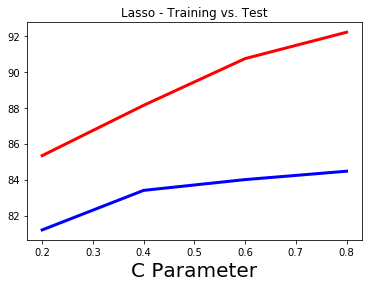

In [31]:
run_model('Lasso')

In [32]:
lr_lasso = LogisticRegression(penalty='l1', C=0.8)
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(900, 1590) (900,)
Training set score: 0.9766666666666667

Test set score: 0.87


## Now try SVM

In [38]:
#Find the right parameters for SVM

from sklearn.svm import SVC

def run_model(model):
    if model == 'SVC':
        svc = np.arange(0.2, 1.0, 0.2)
        svc_df = pd.DataFrame()
        for i in svc:
            svm = SVC(C=i)
            svm.fit(X, Y)
            positive_pred = svm.predict(X)
            cross_val = cross_val_score(svm, X, Y, cv=5).mean()*100
            score = svm.score(X, Y)*100
            svc_df_temp = pd.DataFrame({'C': i, 'training': score, 'test': cross_val}, index=[0])
            svc_df = svc_df.append(svc_df_temp)
        plt.plot(svc_df['C'], svc_df['training'], color = 'r', linewidth = 3, label='Training')
        plt.plot(svc_df['C'], svc_df['test'], color = 'b', linewidth = 3, label='Test')
        plt.xlabel('C Parameter', fontsize=20)
        plt.title('SVC - Training vs. Test', fontsize=30)
        plt.show()

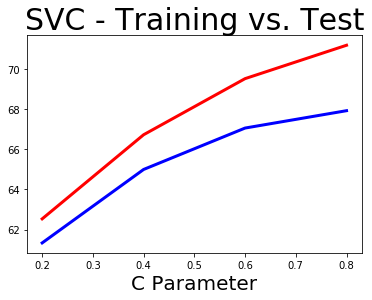

In [39]:
run_model('SVC')

In [40]:
from sklearn.svm import SVC

svm = SVC(C=0.8)
train = svm.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', svm.score(X_train, y_train))
print('\nTest set score:', svm.score(X_test, y_test))

(900, 1590) (900,)
Training set score: 0.6988888888888889

Test set score: 0.6566666666666666


# Challenge 1:
Find out whether your new model is good at identifying Alice in Wonderland vs any other work, Persuasion vs any other work, or Austen vs any other work.  This will involve pulling a new book from the Project Gutenberg corpus (print(gutenberg.fileids()) for a list) and processing it.

Record your work for each challenge in a notebook and submit it below.

In [41]:
# Load and clean the data.
moby = gutenberg.raw('melville-moby_dick.txt')

#Due to computational purposes, reduce size of moby
moby = moby[0:1000000]

# The Chapter indicator is idiosyncratic
moby = re.sub(r'CHAPTER .*', '', moby)

#Run text cleaner
moby = text_cleaner(moby)

In [42]:
# Parse the cleaned novels. This can take a bit.
nlp = spacy.load('en')
moby_doc = nlp(moby)

In [43]:
# Group into sentences.
moby_sents = [[sent, "Melville"] for sent in moby_doc.sents]

print(len(moby_sents))

7819


In [44]:
#For computational purposes, reduce length of moby_sents to 750
moby_sents = moby_sents[0:750]

In [45]:
# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(alice_sents + moby_sents)
sentences.head()

,0,1
0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,"(So, she, was, considering, in, her, own, mind...",Carroll
2,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,"(Oh, dear, !)",Carroll
4,"(I, shall, be, late, !, ')",Carroll


In [46]:
# Set up the bags.
mobywords = bag_of_words(moby_doc)

# Combine bags to create a set of unique words.
common_words = set(alicewords + mobywords)

# Create our data frame with features. This can take a while to run.
word_counts_revised = bow_features(sentences, common_words)
word_counts_revised.head()

Processing row 0
Processing row 500
Processing row 1000


,directly,now,ginger,bulk,knot,tart,grasp,people,reach,coil,...,however,accord,impossible,eh,offend,cruise,dog,thump,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(So, she, was, considering, in, her, own, mind...",Carroll
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Oh, dear, !)",Carroll
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(I, shall, be, late, !, ')",Carroll


**Feature Engineering on Revised Word Count DataFrame

First, count of Parts of Speech

In [47]:
#Create unique column for each pos in words_count

pos_types = set(get_pos(word_counts_revised))
pos = pd.DataFrame(columns=pos_types)
word_counts_revised = pd.concat([word_counts_revised, pos], axis=1)
word_counts_revised.loc[:, pos_types] = 0

In [48]:
#Finally, produce counts for each entity by sentence

for i, sentence in enumerate(word_counts_revised['text_sentence']):
    for token in sentence:
        if token.pos != 0:
            word_counts_revised.loc[i, token.pos_] += 1

Second, count of Entities

In [49]:
#Create unique column for each entity in words_count

entity_types = set(get_entity_types(word_counts_revised))
entities = pd.DataFrame(columns=entity_types)
word_counts_revised = pd.concat([word_counts_revised, entities], axis=1)
word_counts_revised.loc[:, entity_types] = 0

In [50]:
#Finally, produce counts for each entity by sentence

for i, sentence in enumerate(word_counts_revised['text_sentence']):
    for token in sentence:
        if token.ent_type != 0:
            word_counts_revised.loc[i, token.ent_type_] += 1

Finally, count of Words

In [51]:
#Count of words in sentence

word_counts_revised['word_count'] = 0

for i, sentence in enumerate(word_counts_revised['text_sentence']):
    words = len([token for token in sentence if not token.is_punct])
        
    # Populate the row with word counts.
    word_counts_revised.loc[i, 'word_count'] += words

## Now run the Model

In [52]:
lr = LogisticRegression()
Y = word_counts_revised['text_source']
X = word_counts_revised.drop(['text_sentence','text_source'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = lr.fit(X_train, y_train)

print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

Training set score: 0.97

Test set score: 0.8233333333333334


## Conclusion

Based on the last model iteration, we are able to successfully predict Carrol (Alice in Wonderland) vs. Melville (Moby Dick).